# Import Libraries and Data

In [469]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline
from sklearn import linear_model, ensemble, gaussian_process
import seaborn as sns
from sklearn import metrics, decomposition, datasets, preprocessing
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score
from scipy.interpolate import UnivariateSpline
from mpl_toolkits.mplot3d import Axes3D
from sklearn.utils import shuffle, resample
from scipy.stats.kde import gaussian_kde
from sklearn.kernel_ridge import KernelRidge
from numpy import loadtxt
from xgboost import XGBRegressor, XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPRegressor
import warnings; warnings.simplefilter('ignore')

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

plt.rcParams['font.size'] = 24
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = (12,12)
plt.rcParams['axes.linewidth'] = 6.0


#File Imports
filePath = ''  # (° ͜ʖ ͡°) 
df_train_init = pd.read_csv(filePath + 'data/equip_failures_training_set.csv')
df_test_init = pd.read_csv(filePath + 'data/equip_failures_test_set.csv')

#Filling na values for nan
df_train_init.replace('na', 'nan', inplace = True)
df_test_init.replace('na', 'nan', inplace = True)

# Data Imputing

In [383]:
##Data imputing does't need to be used for XGBoost but for the other classifiers, they cannot handle NaN values,
##so the data must be imputed. Here we use two different methods

import numpy as np
from sklearn.impute import SimpleImputer
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

##This data imputing method is strictly averaging the columns and filling the NaN with the column avg. Very short computing time
# imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
# imp_mean.fit(df_train)
# df_train=pd.DataFrame(imp_mean.transform(df_train),columns=df_train.columns)

#Very expensive imputing technique, essentially treats every NaN as a y=mx+b problem, solving for y using nearest neighbor data
##Feel free to run this, but the .csv is also saved from this method for easy and quick implementation
imp = IterativeImputer(max_iter=10, random_state=0)
imp.fit(df_train_init)  
imp_df_train=pd.DataFrame(imp.transform(df_train_init),columns=df_train_init.columns)
imp_df_train.to_csv('iterimputed_train.csv')

In [399]:
##Same thing was done to the test data set
imp = IterativeImputer(max_iter=10, random_state=0)
imp.fit(df_test_init)  
imp_df_test=pd.DataFrame(imp.transform(df_test_init),columns=df_test_init.columns)
imp_df_test.to_csv('iterimputed_test.csv')

In [401]:
##Reading in the imputed data
df_train = pd.read_csv('iterimputed_train.csv')
df_test = pd.read_csv('iterimputed_test.csv')

In [402]:
##Splitting the data by target value
df_train1=df_train[df_train['target']==1]
df_train0=df_train[df_train['target']==0]

##Setting up the features or our 'X' in the model by searching for sensor strings
filter_col = [col for col in df_test if col.startswith('sensor')]
df_test_descriptors = df_test[filter_col].astype('float32')

# Model Creation, Feature Importance, and Prediction


Chosen Model:  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=2, verbose=0,
                       warm_start=False)
Accuracy: 95.27%


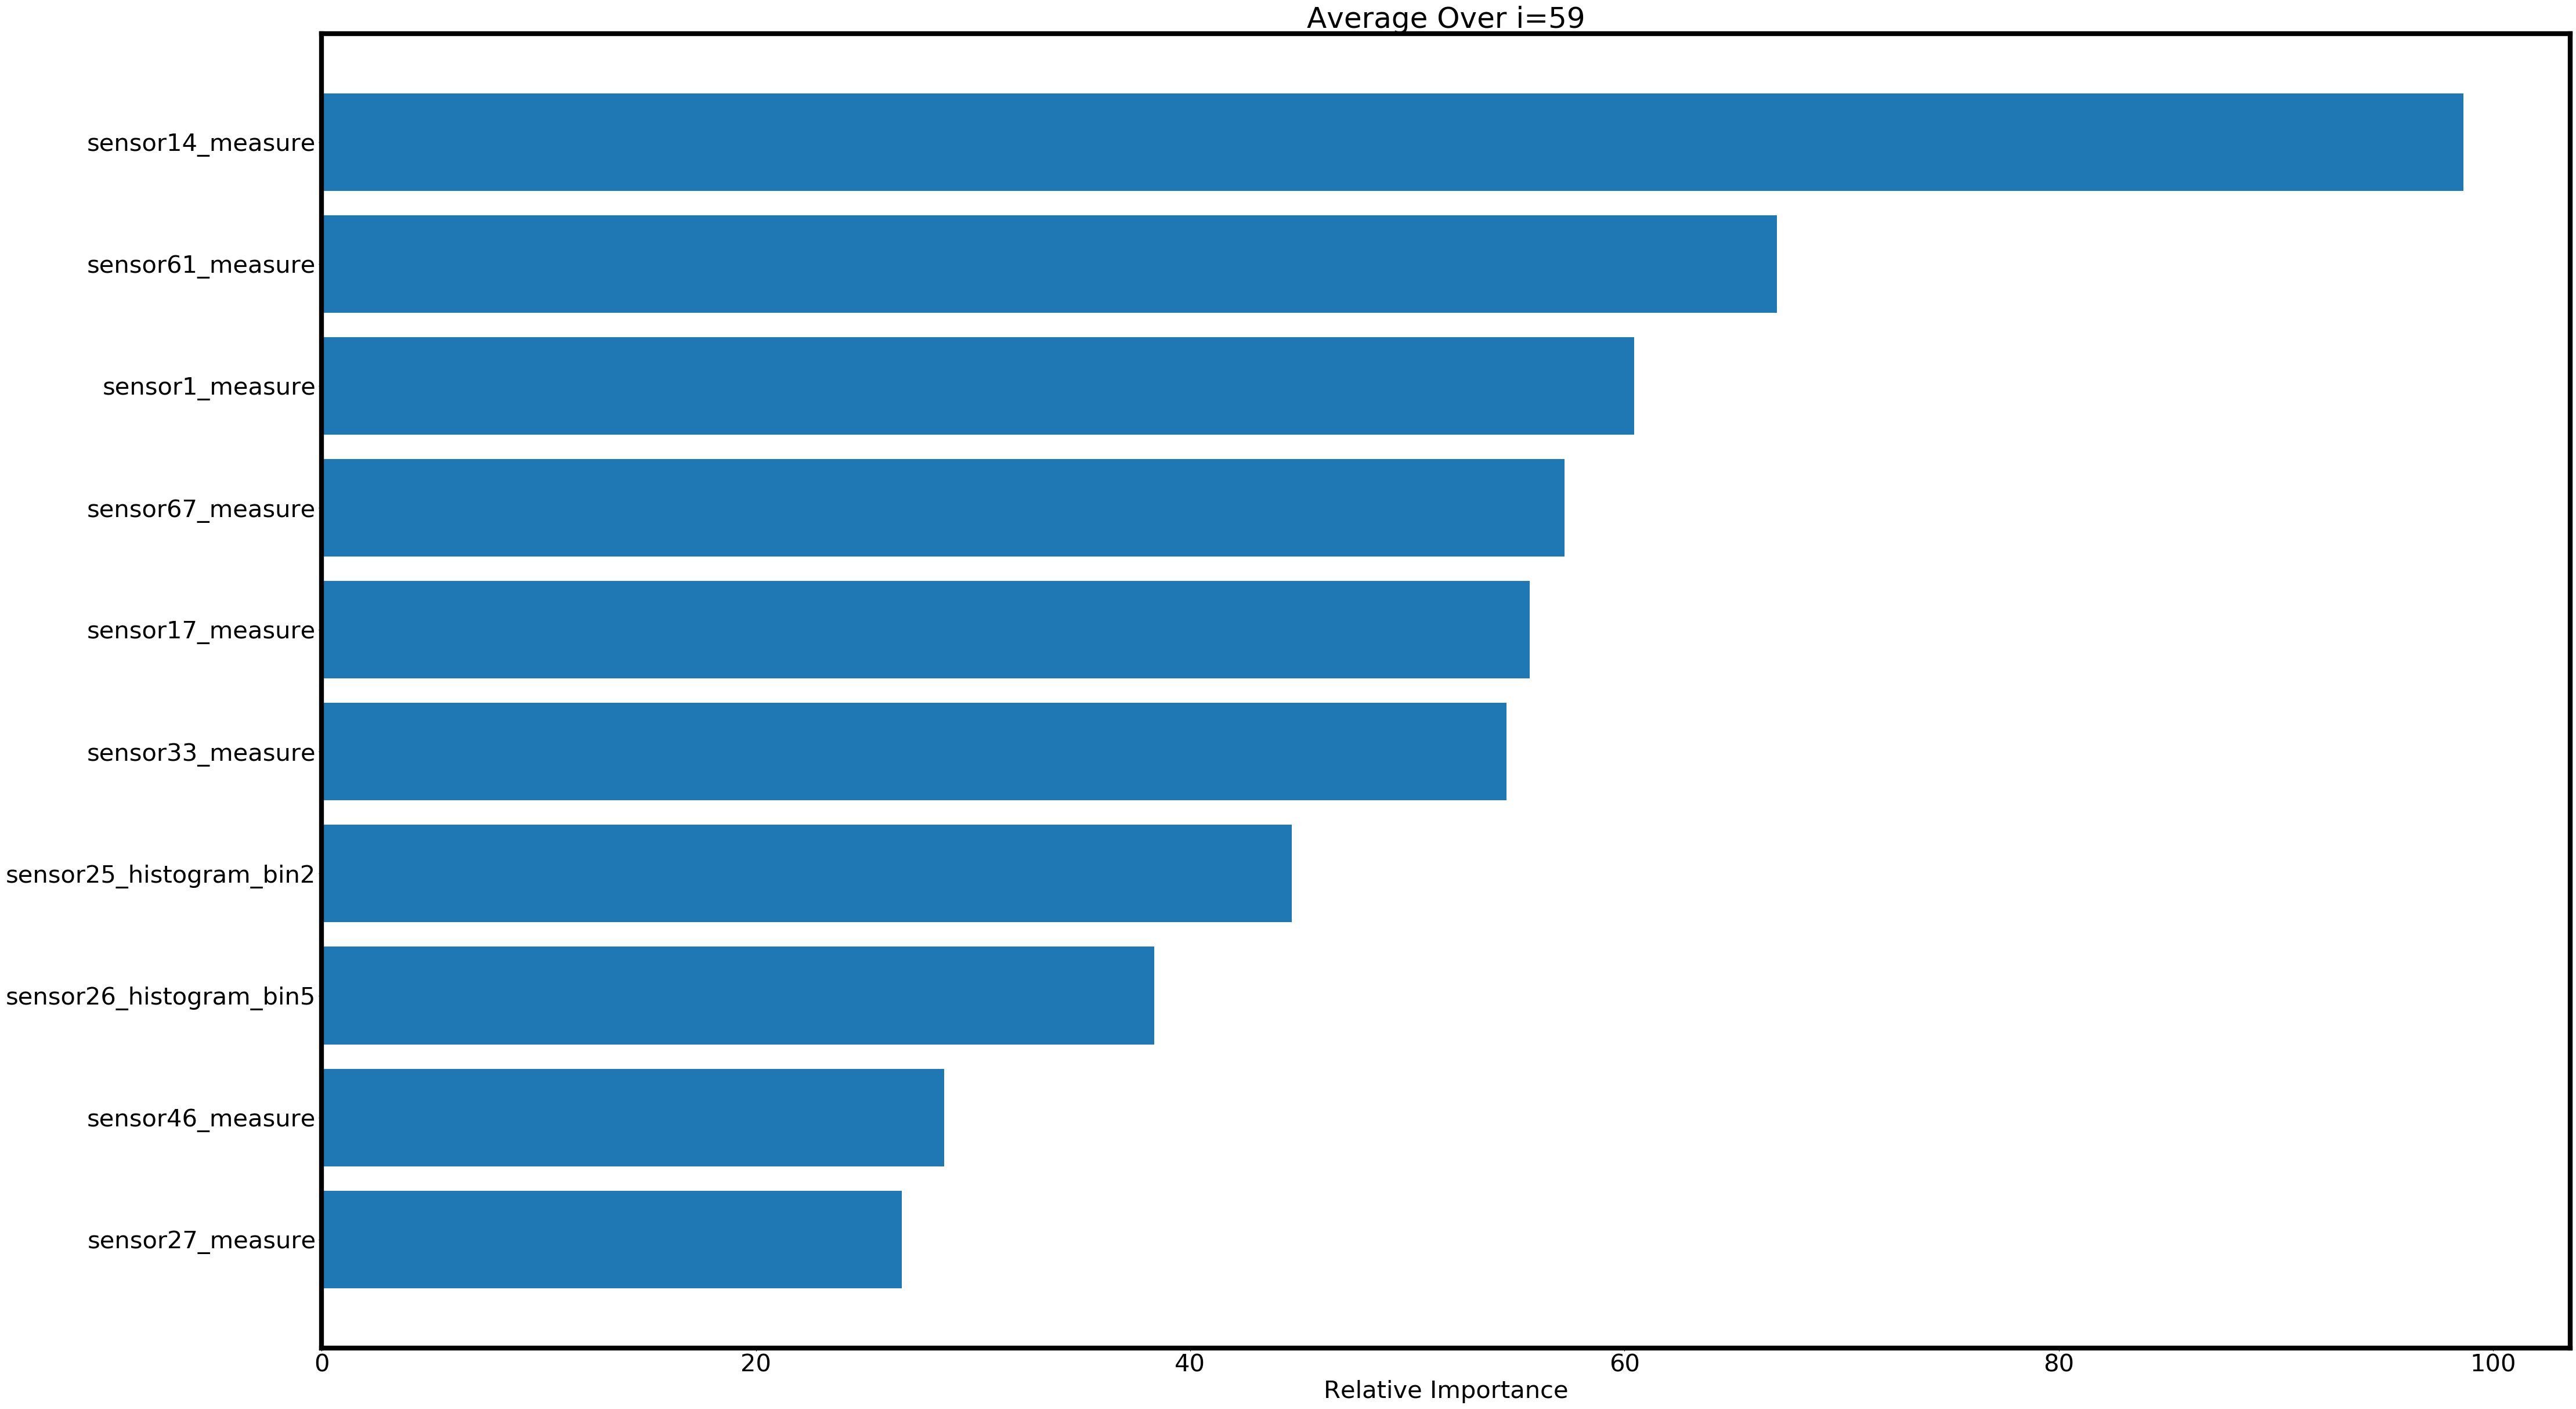


Chosen Model:  GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.12, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=600,
                           n_iter_no_change=None, presort='auto',
                           random_state=1234, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
Accuracy: 96.13%


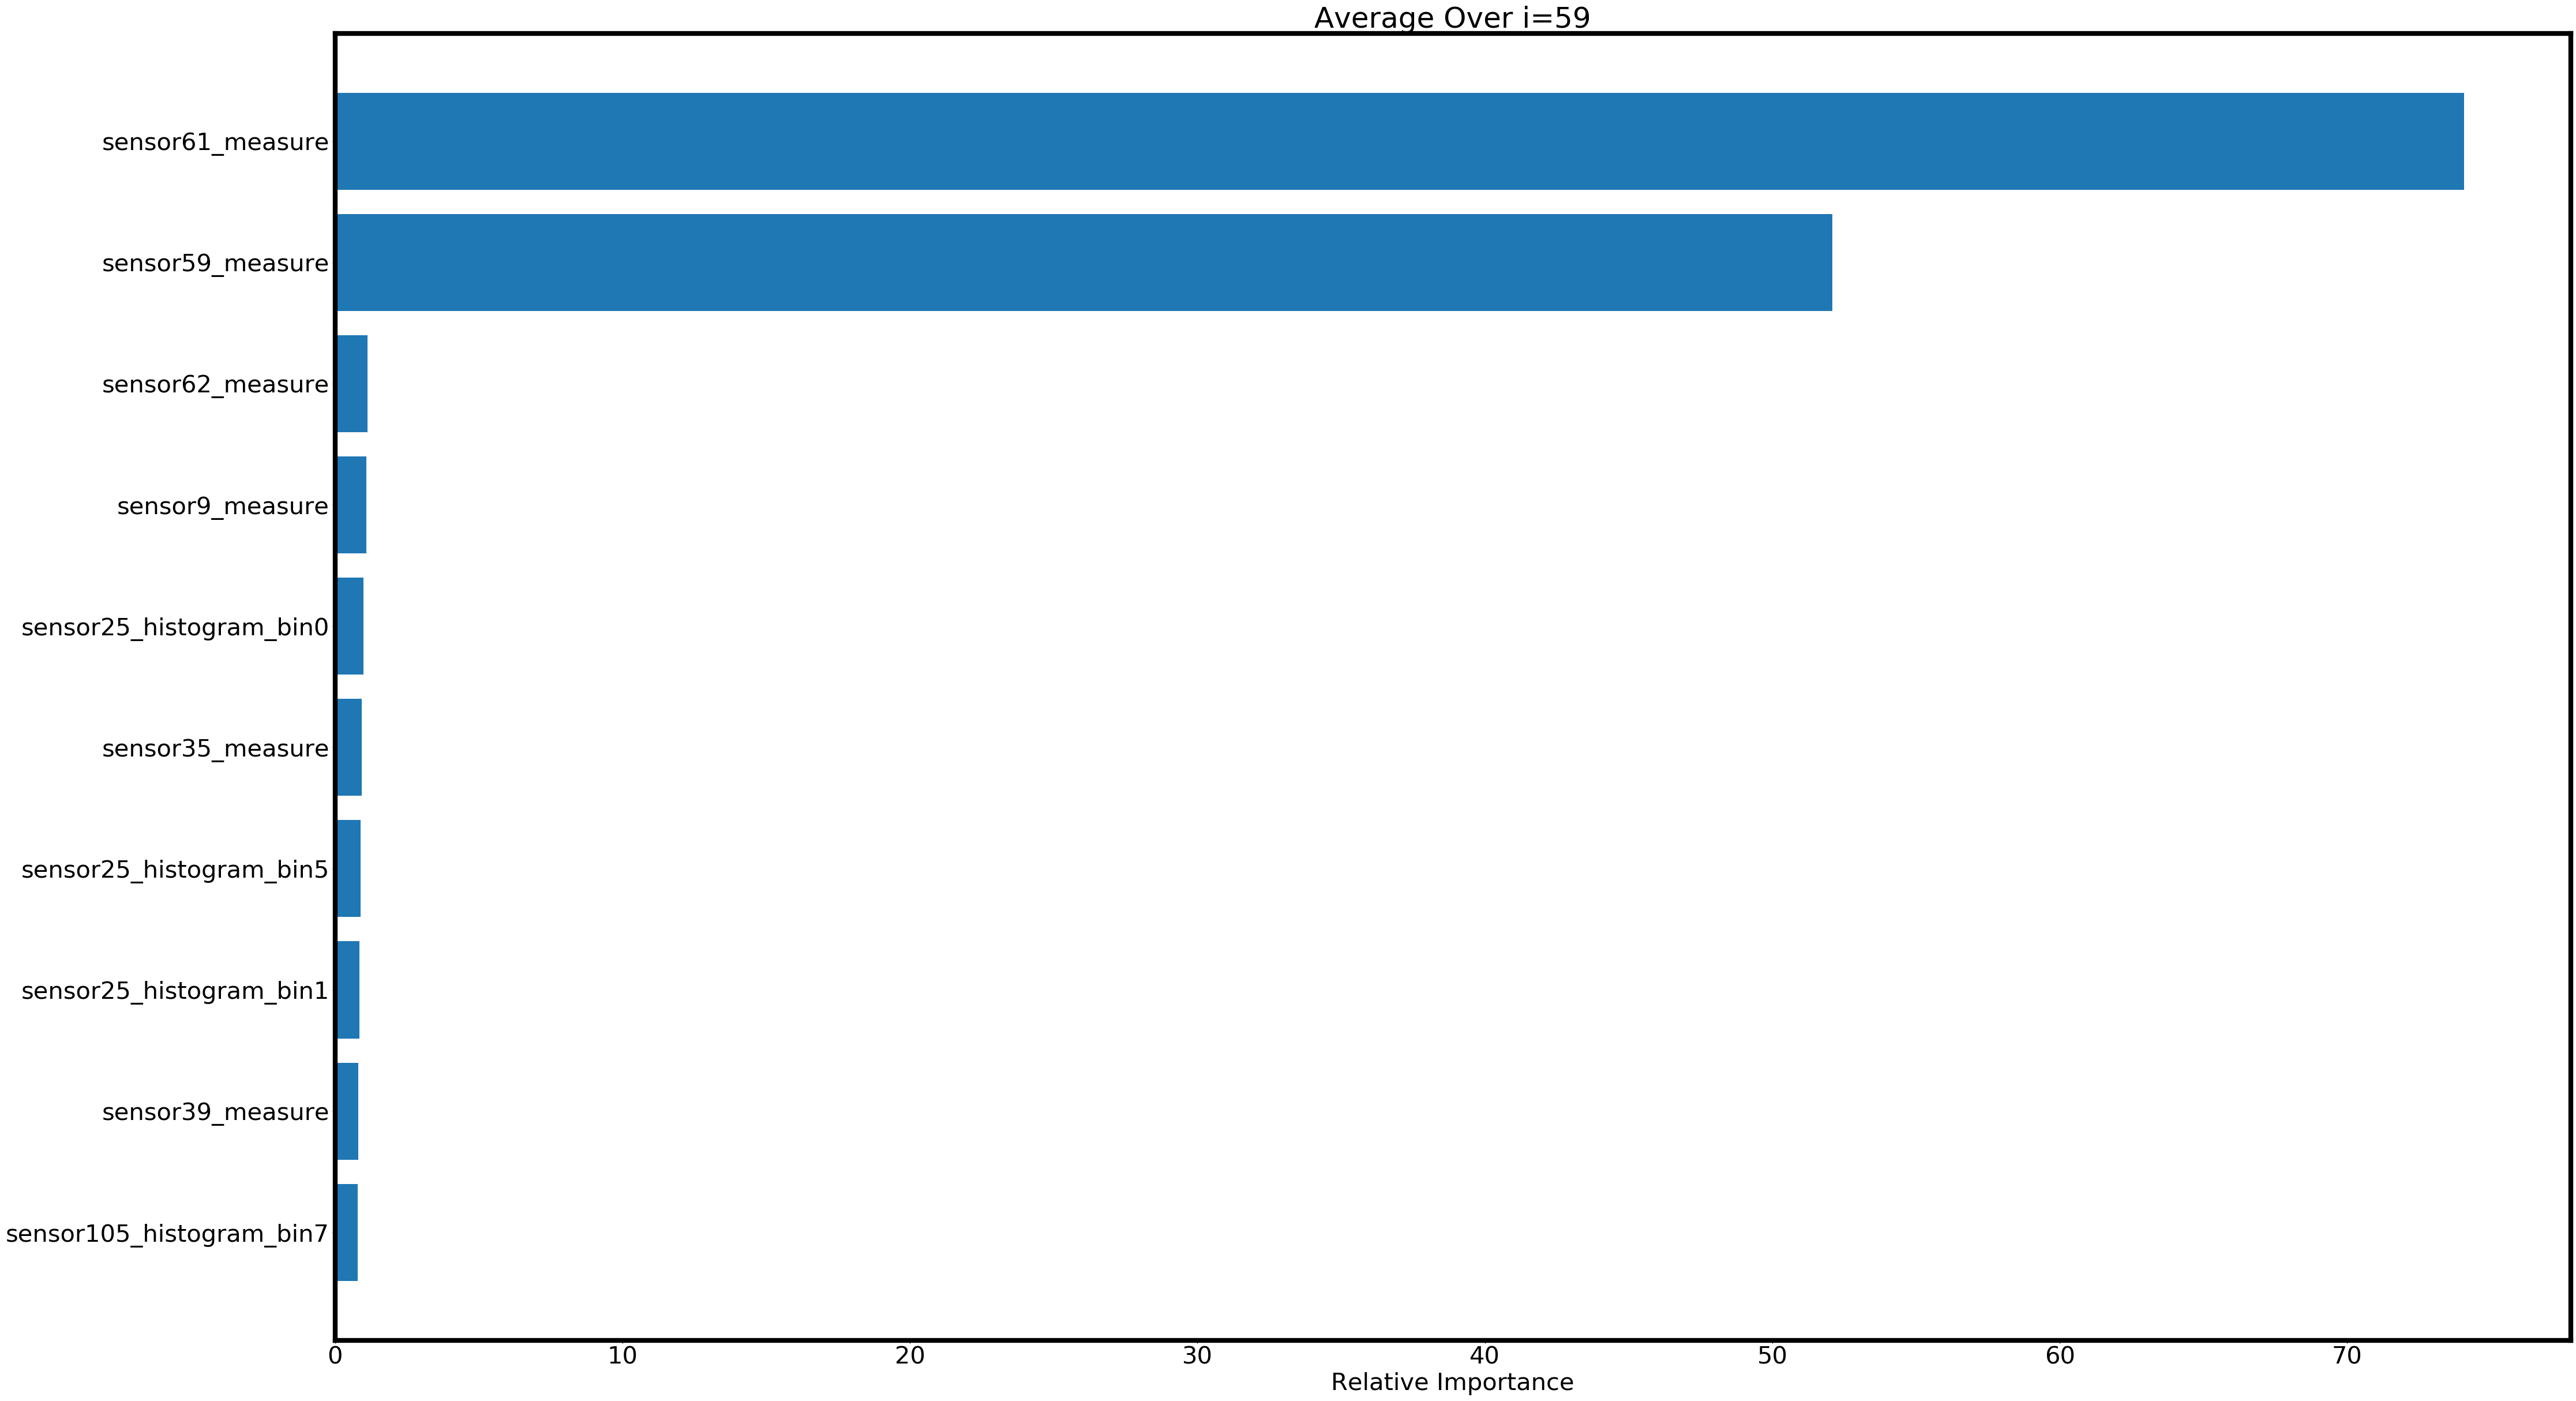


Chosen Model:  XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.12, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=600, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=1234,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.8, verbosity=1)
Accuracy: 96.08%


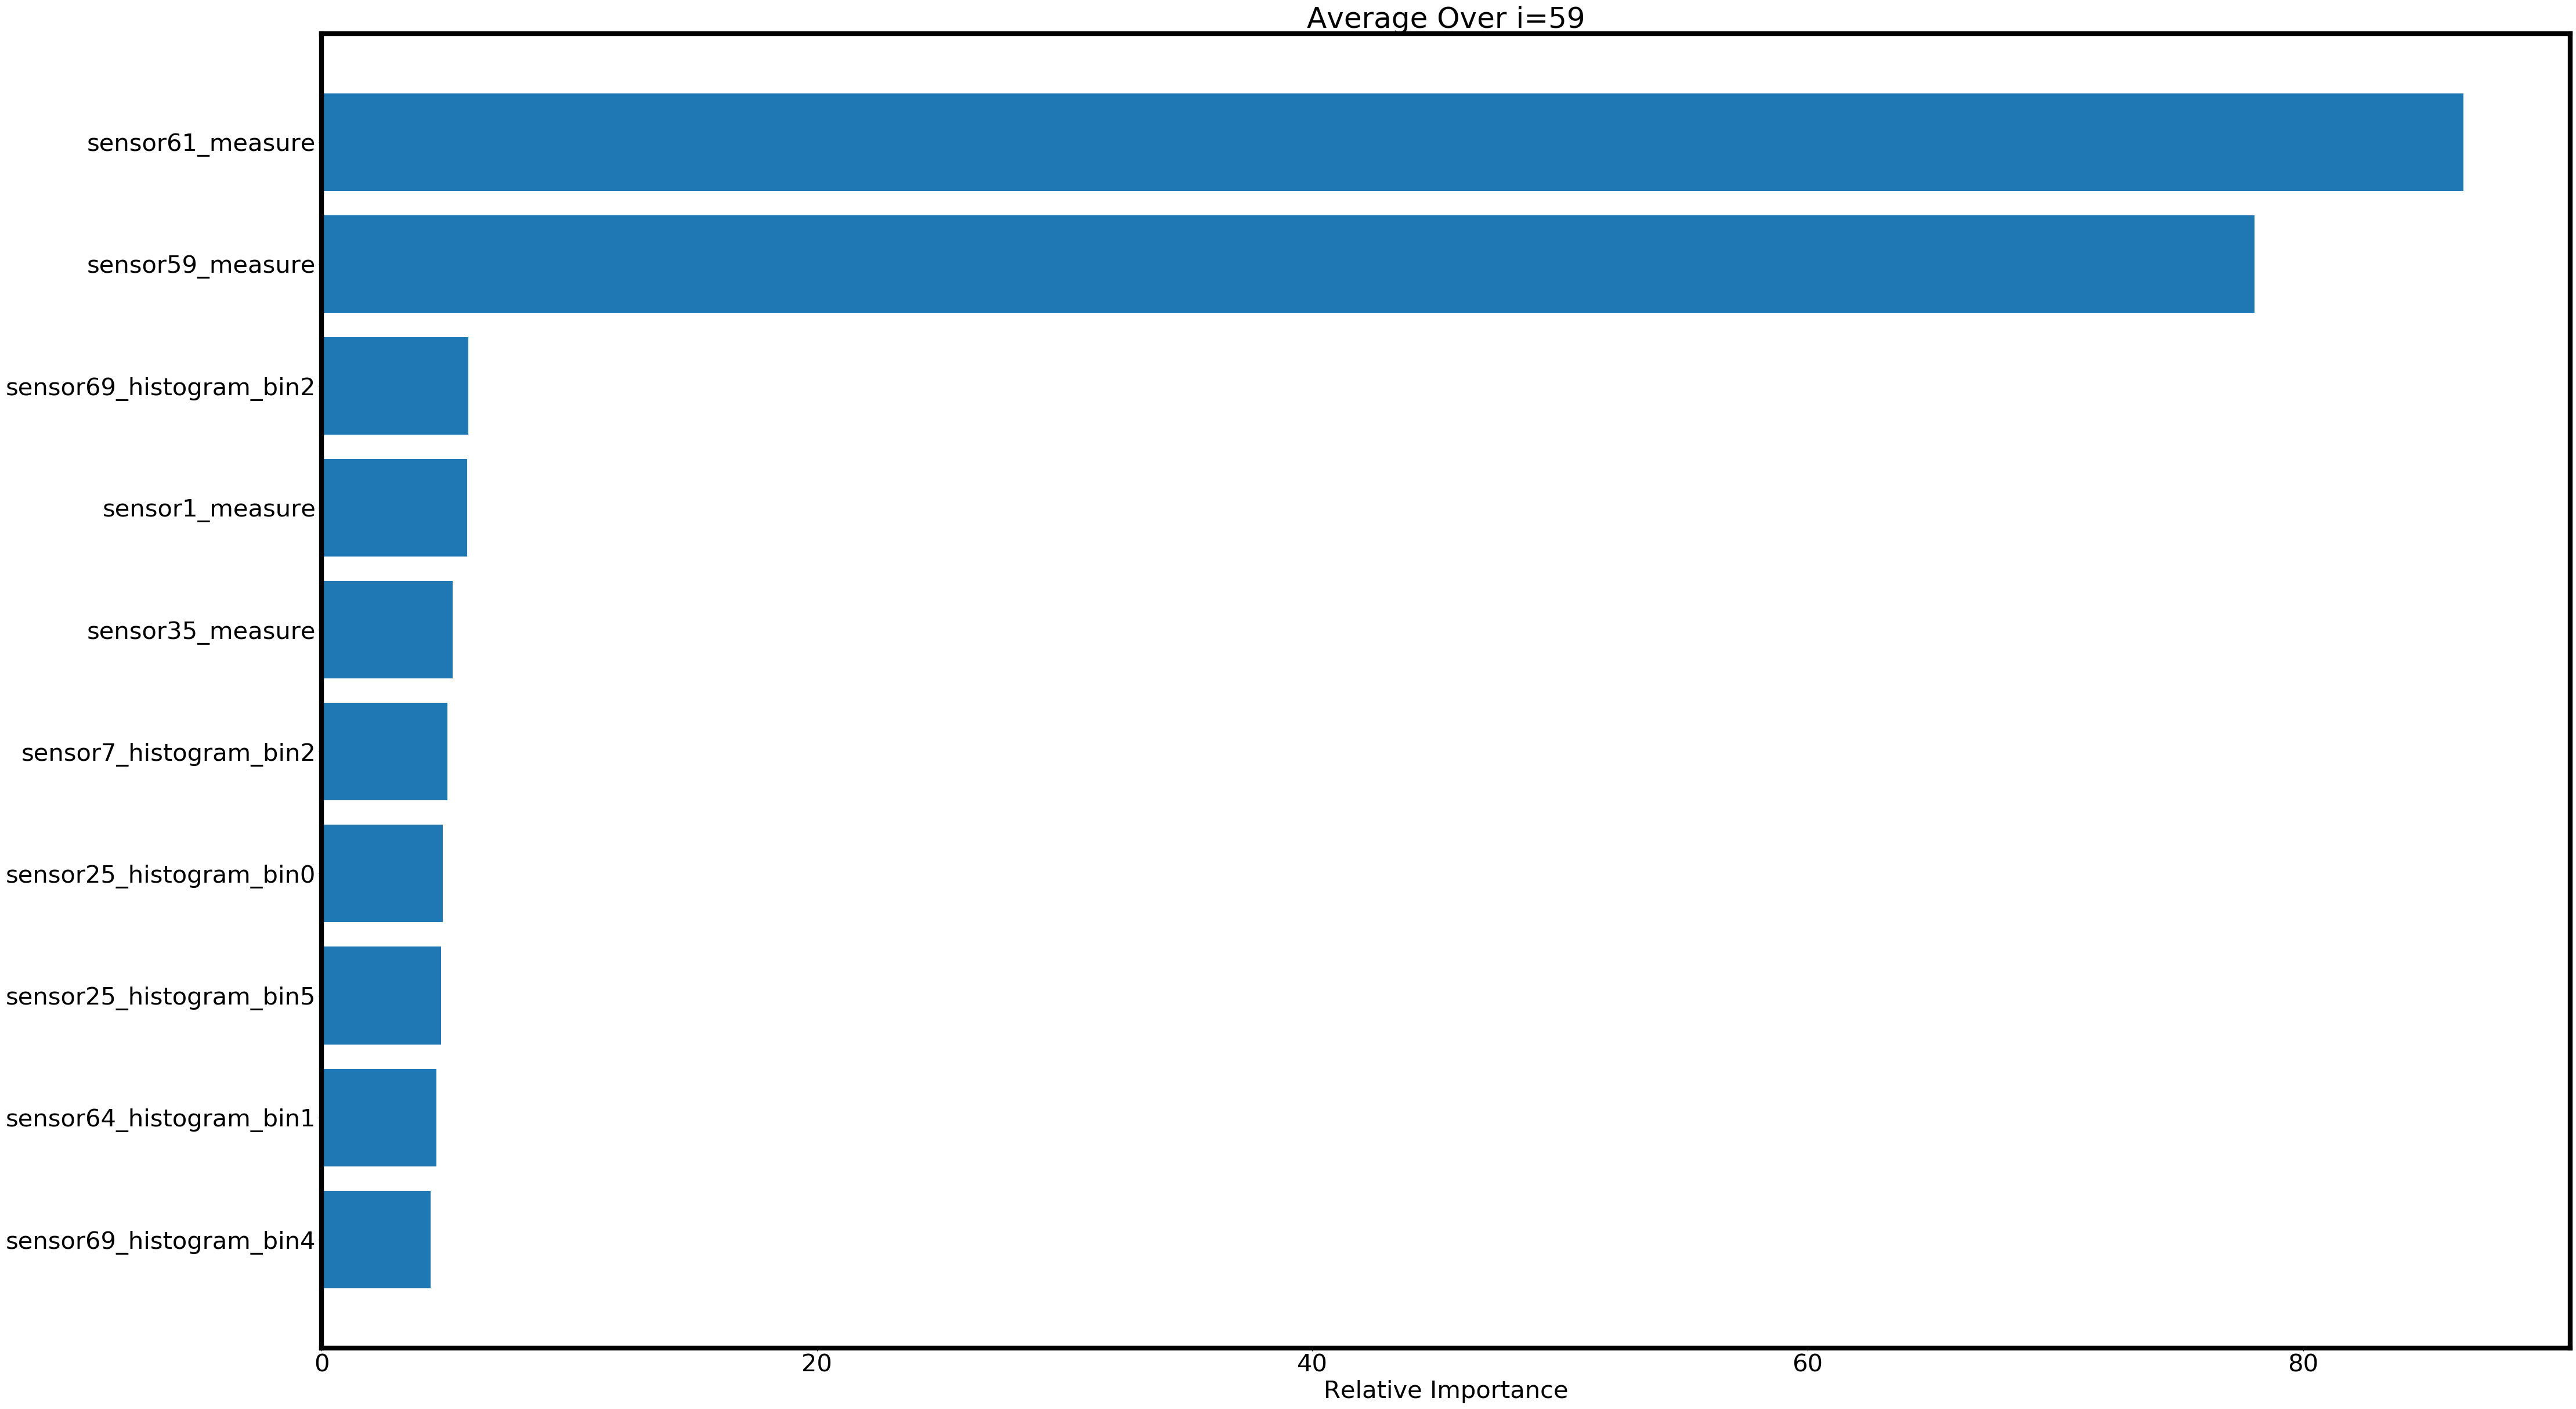

In [559]:
##Initializing dataframes to append out of loops
test_pred_avg=pd.DataFrame()
test_pred_yeet=pd.DataFrame()

plt.rcParams['figure.figsize'] = (50,30)
plt.rcParams['font.size'] = 30

##Choosing models for classification. These were optimized initially with HyperOpt Library (utilizes Bayesian optimization),
##then manually adjusted further for improvemnt
modelz=[ensemble.RandomForestClassifier(n_estimators=10, max_depth=None,random_state=2),
        ensemble.GradientBoostingClassifier(learning_rate= .12, max_depth=4, n_estimators= 600, random_state=1234),
        XGBClassifier(learning_rate=.12, max_depth=4, n_estimators=600, random_state=1234, subsample=0.8,objective='binary:logistic')
        ]

##Begin iterating through model list
for mo in modelz:
    print('\nChosen Model: ', mo)
    
    ##Initilize more variables
    acc_all = []
    fi_all = pd.DataFrame()
    test_pred=pd.DataFrame()
    
    ##The next bit is iterating through (100 times) randomly undersampling from the data with target=0. This is because 
    ##the data is unbalanced 1 to 59, skewing any classification accuracy. You are able to achive accuracy of 98.33% by just predicting
    ##zeroes for the targets. 
    for i in range(100):
        
        ##Here is the random sampling section
        seed = np.random.RandomState(seed=None)
        df_train0=df_train0.sample(n = df_train1.shape[0], replace = False, random_state=seed);
        df_train_rs = pd.concat([df_train0, df_train1], axis=0)
        
        ##Filtering for feature columns and setting target
        filter_col = [col for col in df_train_rs if col.startswith('sensor')]
        descriptors = df_train_rs[filter_col].astype('float32')
        target=df_train_rs["target"].astype('float32')
        y=target
        X=descriptors

        clf = mo
        # split data into train and test sets
        test_size = 0.15
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)
        
        # fit the model and test for accuracy
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)

        ##Predict the test data csv
        y_test_pred = clf.predict(df_test_descriptors)
        
        #Extracting feature importance from the models
        feature_importance = clf.feature_importances_
        feature_importance = 100.0 * (feature_importance / feature_importance.max())
        
        ##Appending data for model averaging outside of this innner for loop
        fi_all[i]=feature_importance
        acc_all.append(accuracy)
        test_pred[i]=y_test_pred

    #Printing average model accuracy (R2 scores) for each model    
    print("Accuracy: %.2f%%" % (np.mean(acc_all) * 100.0))
    
    #Weighting the feature importance by the model accuracy of each iteration
    fi_norm=fi_all*acc_all/np.sum(acc_all)
    fi_avg=fi_norm.sum(axis=1)
    
    #Weighting the predictions by the model accuracy of each iteration
    test_pred_yeet=test_pred*acc_all/np.sum(acc_all)
    test_pred_avg[str(mo)[:10]]=test_pred_yeet.sum(axis=1)
    
    #Creating bar chart for Important Features
    sorted_idx = np.argsort(fi_avg)[X.shape[1]-10:]
    pos = np.arange(sorted_idx.shape[0]) + .5
    imp_features=X.columns[sorted_idx]
    plt.barh(pos, fi_avg[sorted_idx], align='center')
    plt.yticks(pos, X.columns[sorted_idx])
    plt.xlabel('Relative Importance')
    plt.show()

In [562]:
##This section is to filter predictions by a threshold/confidence. Because of the model averaging, a probability of classification is created
##Here we consider everything with probability of failure >0.9833 to be target=1. This threshold can be tuned based on the
##type of error the user wants to allow for (Type I or Type II errors)
test_pred_avg_done=test_pred_avg.mean(axis=1)
np.array(test_pred_avg_done.values.tolist())
for count, i in enumerate(test_pred_avg_done):
    if i>.9833:
        test_pred_avg_done[count]=1
    else:
        test_pred_avg_done[count]=0

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
5        0.0
6        0.0
7        0.0
8        0.0
9        0.0
10       0.0
11       0.0
12       0.0
13       0.0
14       0.0
15       0.0
16       0.0
17       1.0
18       0.0
19       1.0
20       0.0
21       0.0
22       0.0
23       0.0
24       0.0
25       0.0
26       0.0
27       0.0
28       0.0
29       0.0
30       0.0
31       0.0
32       0.0
33       0.0
34       0.0
35       0.0
36       0.0
37       0.0
38       0.0
39       0.0
40       0.0
41       0.0
42       0.0
43       0.0
44       1.0
45       0.0
46       0.0
47       0.0
48       0.0
49       0.0
50       0.0
51       0.0
52       0.0
53       0.0
54       0.0
55       0.0
56       0.0
57       0.0
58       0.0
59       0.0
60       0.0
61       0.0
62       0.0
63       0.0
64       0.0
65       0.0
66       0.0
67       1.0
68       0.0
69       0.0
70       0.0
71       0.0
72       0.0
73       0.0
74       0.0
75       0.0
76       0.0

In [563]:
test_pred_avg_done.value_counts()

0.0    15065
1.0      936
dtype: int64

In [564]:
##Finalizing predictions and putting them into the .csv file for submission
solution=pd.DataFrame()
solution['id']=df_test_init['id']
solution['target']=test_pred_avg_done
solution.to_csv('solution.csv',index=False)

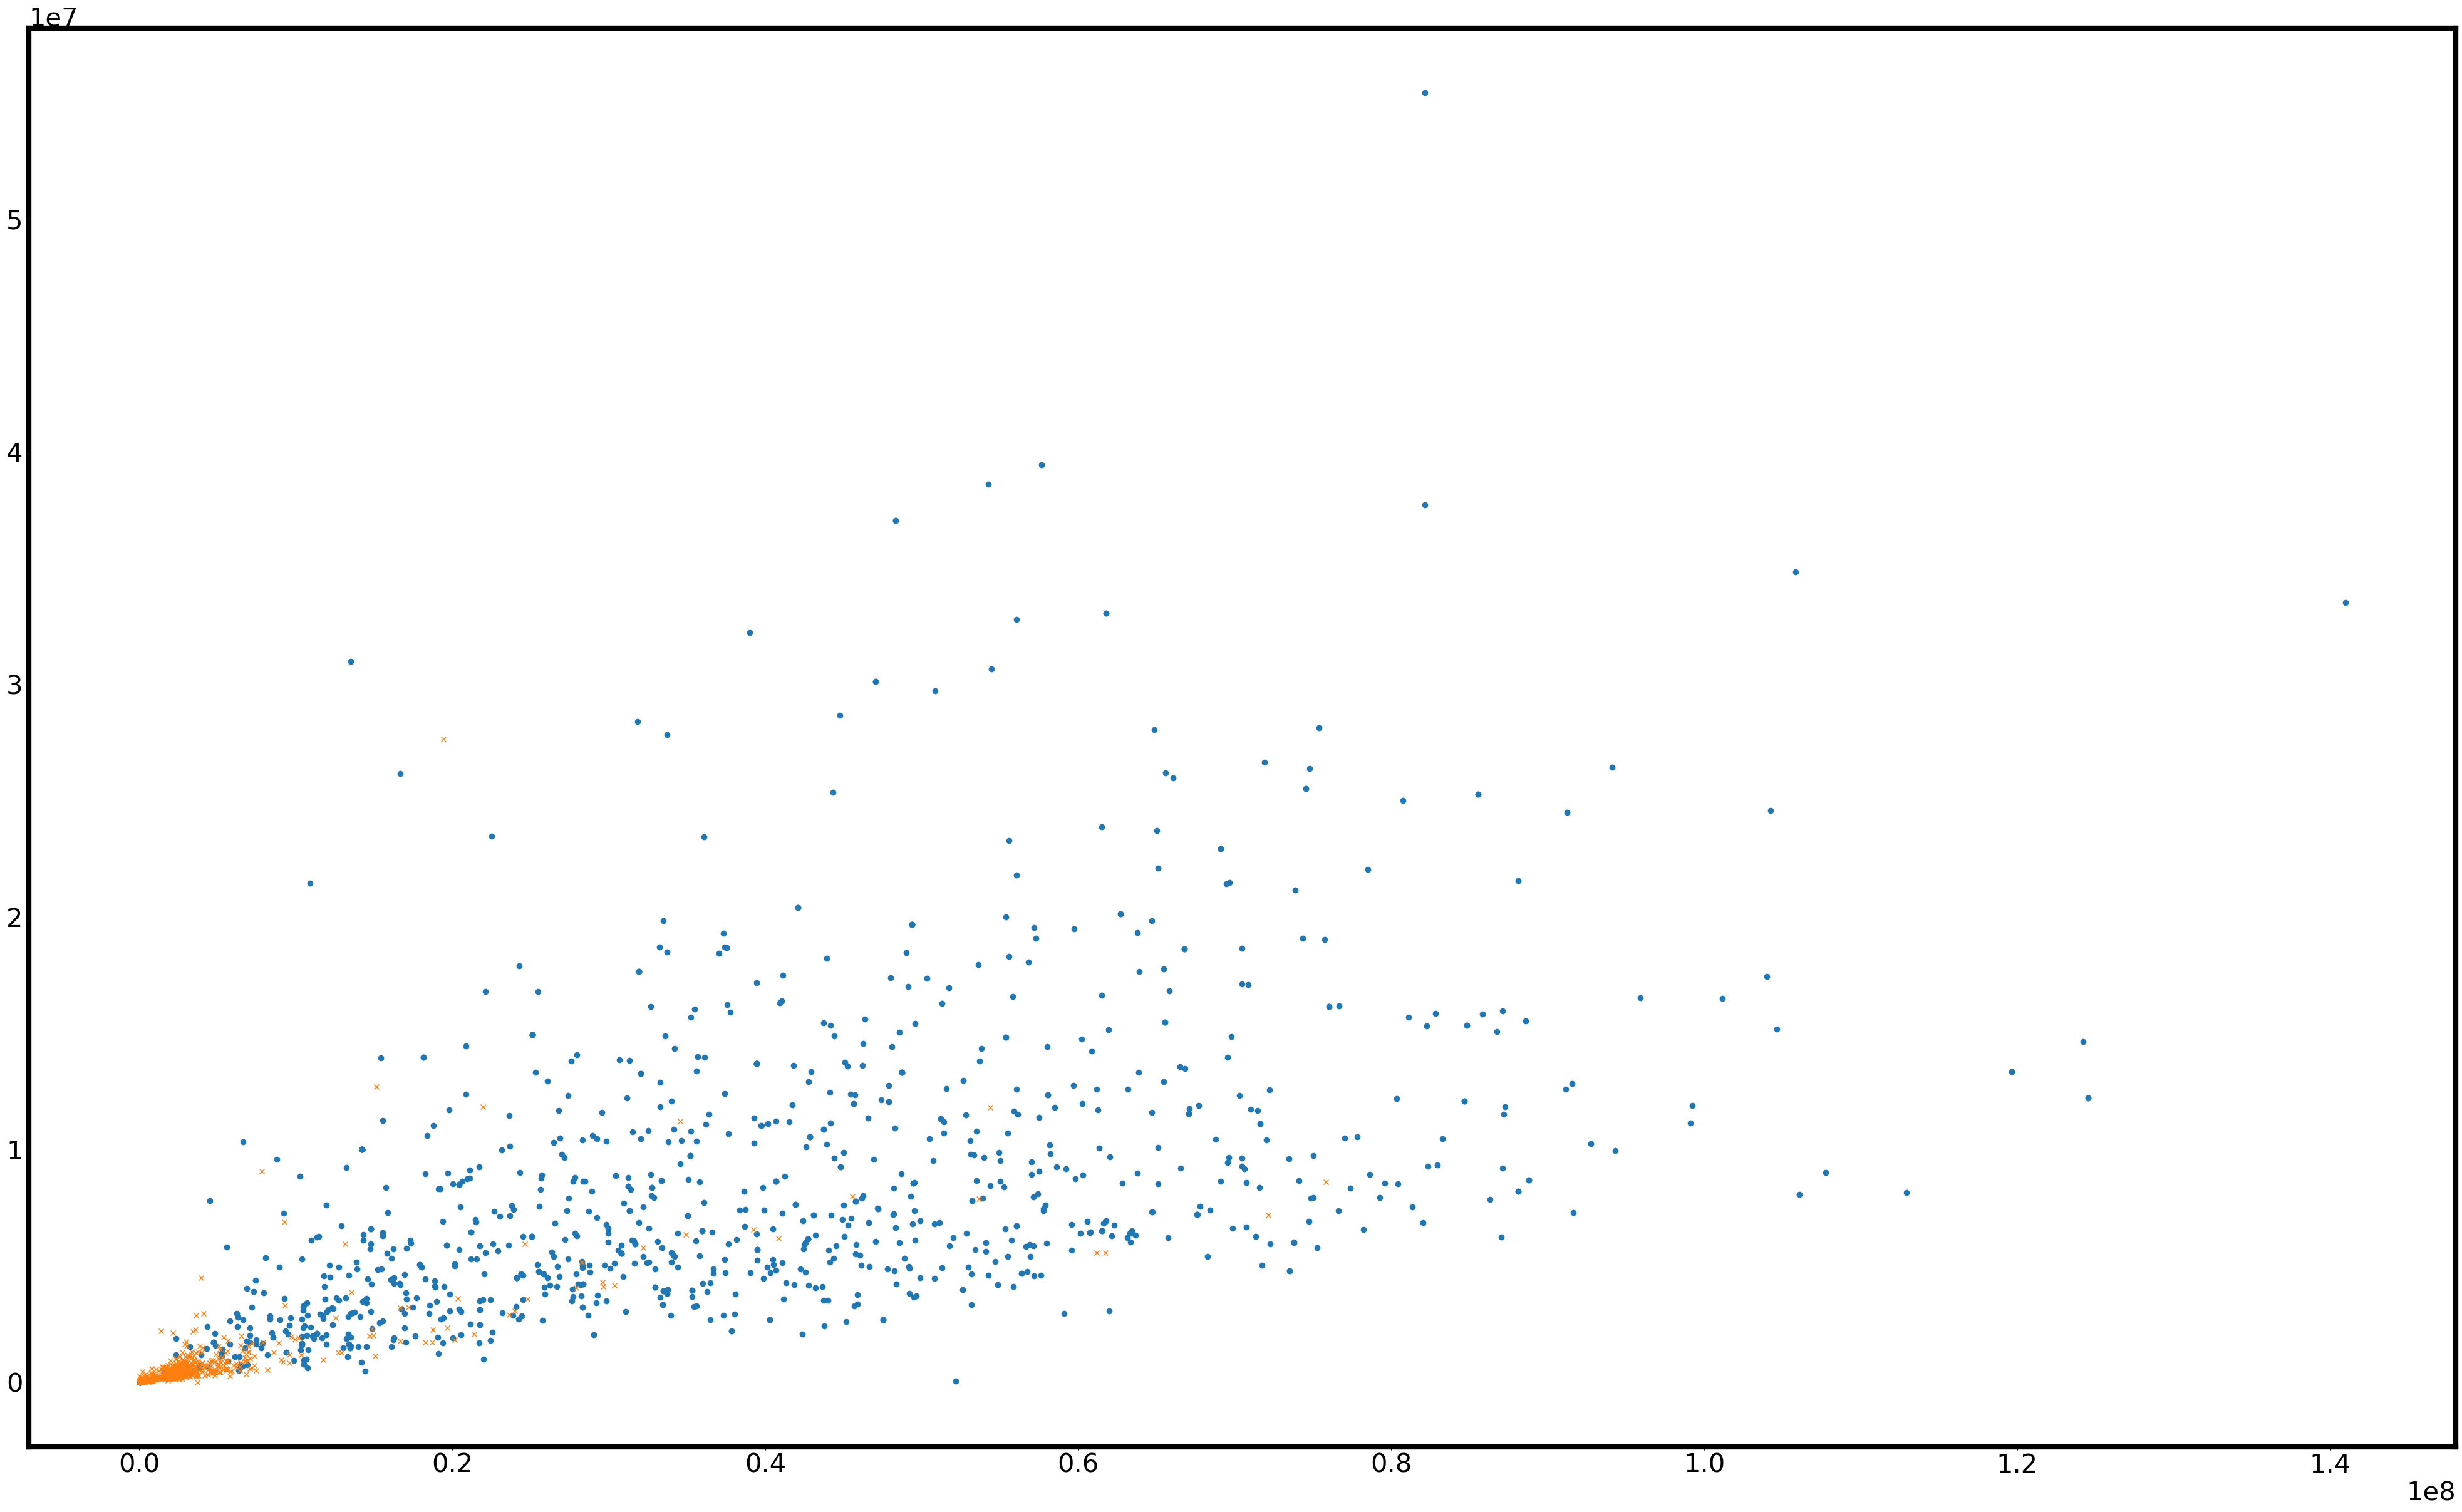

In [494]:
##Simple plotting to visualize these two naughty features and their influence on the target value
y=df_train1['sensor61_measure']
x=df_train1['sensor59_measure']
y2=df_train0['sensor61_measure']
x2=df_train0['sensor59_measure']
plt.plot(x, y, 'o')#, t, p(t), '-')
plt.plot(x2,y2,'x')
plt.show()